# Initial setup:

* Import what we need from sklearn, numpy, and matplotlib
* Make matplotlib inline since we're in notebook
* Plotting code ripped from http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html 

In [420]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import pandas as pd
import multiprocessing

%matplotlib inline

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def splitInputOutput(data):
    x, y = np.array(data[:,0:-1], dtype=float), np.array(data[:,-1],dtype=int)
    return x,y.ravel()



Setup some functions to return gridsearch for the individual kernels.
Algorithm will call each of these functions and graph SVMs using best_params_ from each using the above plot functions.



# Helpers

Here we define some methods for configuring and setting up GridSearchCV for linear, polynomial, and gaussian.  This makes it easy to find the best hyperparameters for linear by simply calling search_linear().

In [421]:
"""
Setup some functions to return gridsearch for the individual kernels.
Algorithm will call each of these functions and graph SVMs using best_params_ from each using the above plot functions.
"""
vals=np.array([])
scorer = make_scorer(accuracy_score)

def search_gaussian(X, y, num_folds):
    searchSpace = {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}
    search = GridSearchCV(svm.SVC(kernel='rbf'), searchSpace, n_jobs=multiprocessing.cpu_count(), cv=num_folds, scoring = scorer)
    search.fit(X, y)
    return search

def search_linear(X, y, num_folds):
    searchSpace = {'C': [0.001, 0.01, 0.1, 1, 10]}
    search = GridSearchCV(svm.SVC(kernel='linear'), searchSpace, cv=num_folds, scoring=scorer)
    search.fit(X, y)
    return search

def search_polynomial(X, y, num_folds):
    searchSpace = {'C': [0.001, 0.01, 0.1, 1, 10], 'degree' : [2,3]}
    search = GridSearchCV(svm.SVC(kernel='poly'), searchSpace, n_jobs=multiprocessing.cpu_count(), cv=num_folds, scoring = scorer)
    search.fit(X, y)
    return search

# Load trivial sample data

Load a sinusoidal w/ gaussian noise data into X and y. 


In [422]:
np.random.seed(42)

radiansX = np.pi*np.random.random_sample((800,))
cosineX = np.cos(radiansX)+(0.4*np.random.random_sample((800,))-0.2)
classification = np.double(cosineX > np.cos(radiansX))

df = pd.DataFrame({'X': radiansX,'Y':cosineX, 'classification': classification});

X,y = splitInputOutput(df.as_matrix())
print(X.shape)
print(y.shape)

radiansX = np.pi*np.random.random_sample((200,))
cosineX = np.cos(radiansX)+(0.4*np.random.random_sample((200,))-0.2)
classification = np.double(cosineX > np.cos(radiansX))
df = pd.DataFrame({'X': radiansX,'Y':cosineX, 'classification': classification});
tX,ty = splitInputOutput(df.as_matrix())
print(tX.shape)
print(ty.shape)

(800, 2)
(800,)
(200, 2)
(200,)


In [423]:
print("Searching linear...")
linear_search = search_linear(X,y,5)
print(linear_search.best_params_)
print (linear_search)
print()
print ("Best score:", linear_search.best_score_)

Searching linear...
{'C': 10}
GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

Best score: 0.82375


In [424]:
print("Searching polynomial...")
polynomial_search = search_polynomial(X,y,5)
print(polynomial_search.best_params_)
print ("Best score:", polynomial_search.best_score_)

Searching polynomial...
{'C': 10, 'degree': 3}
Best score: 0.955


In [425]:
print("Searching gaussian...")
gaussian_search = search_gaussian(X,y,5)
print(gaussian_search.best_params_)
print ("Best score:", gaussian_search.best_score_)

Searching gaussian...
{'C': 10, 'gamma': 1}
Best score: 0.9775


# Trivial Results

Accuracy of SVC with linear kernel is: 85.5%
Accuracy of LinearSVC (linear kernel) is: 85.0%
Accuracy of SVC with RBF kernel is: 98.0%
Accuracy of SVC with polynomial (degree 3) kernel is: 96.0%


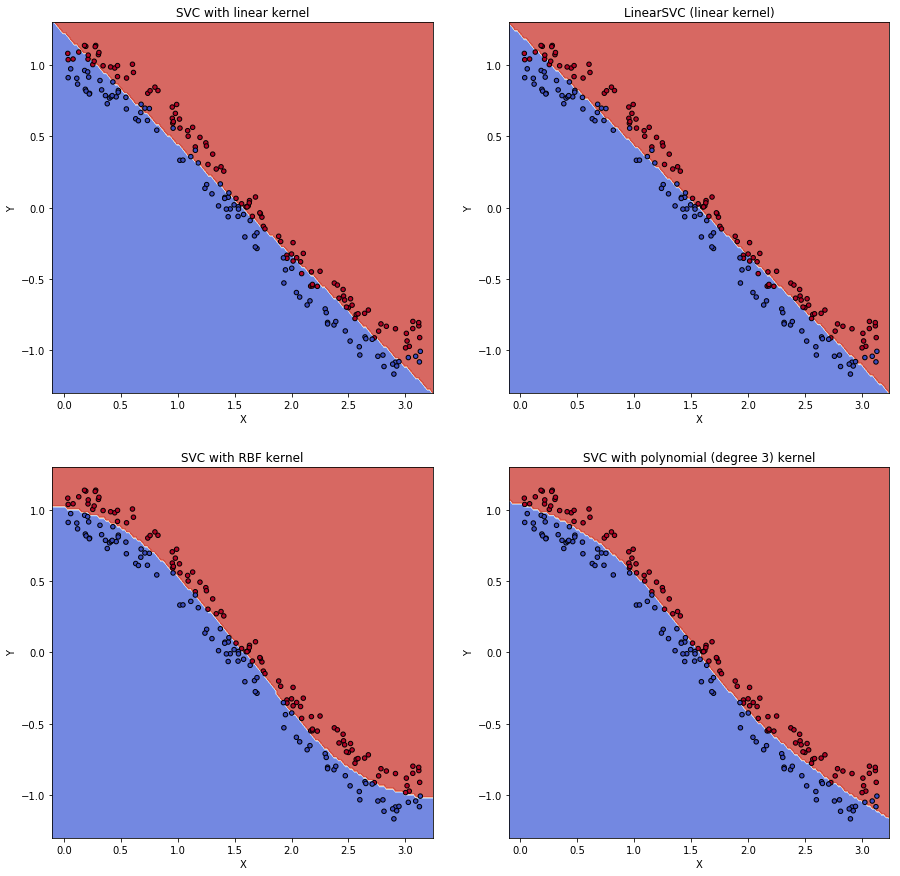

In [426]:
models = (svm.SVC(kernel='linear', C=linear_search.best_params_['C']),
          svm.LinearSVC(C=linear_search.best_params_['C']),
          svm.SVC(kernel='rbf', gamma=gaussian_search.best_params_['gamma'], C=gaussian_search.best_params_['C']),
          svm.SVC(kernel='poly', degree=polynomial_search.best_params_['degree'], C=polynomial_search.best_params_['C']))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree '+str(polynomial_search.best_params_['degree'])+') kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2,figsize=(15,15))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

X0, X1 = tX[:, 0], tX[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    print('Accuracy of ',title,' is: ',clf.score(tX,ty)*100,'%',sep='')
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=ty, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(-0.1, np.pi+0.1)
    ax.set_ylim(-1.3, 1.3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
plt.show()
plt.close()


# Load the real data

In [427]:

#df = pd.read_csv('train.csv',sep=',');
df = pd.read_csv('AltTrain.csv',sep=',');

X,y = splitInputOutput(df.as_matrix())
print(X.shape)
print(y.shape)
#df = pd.read_csv('test.csv',sep=',');
df = pd.read_csv('AltTest.csv',sep=',');

tX,ty = splitInputOutput(df.as_matrix())
print(tX.shape)
print(ty.shape)

(600, 3)
(600,)
(131, 3)
(131,)


In [428]:
print("Searching linear...")
linear_search = search_linear(X,y,5)
print(linear_search.best_params_)
print (linear_search)
print ("Best score:", linear_search.best_score_)

Searching linear...
{'C': 1}
GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)
Best score: 0.925


In [429]:
print("Searching polynomial...")
polynomial_search = search_polynomial(X,y,5)
print(polynomial_search.best_params_)
print ("Best score:", polynomial_search.best_score_)

Searching polynomial...
{'C': 10, 'degree': 2}
Best score: 0.926666666667


In [430]:
print("Searching gaussian...")
gaussian_search = search_gaussian(X,y,5)
print(gaussian_search.best_params_)
print ("Best score:", gaussian_search.best_score_)

Searching gaussian...
{'C': 1, 'gamma': 1}
Best score: 0.923333333333


# Actual Results

Accuracy of SVC with linear kernel is: 94.6564885496%
Accuracy of LinearSVC (linear kernel) is: 93.893129771%
Accuracy of SVC with RBF kernel is: 95.4198473282%
Accuracy of SVC with polynomial (degree 2) kernel is: 95.4198473282%


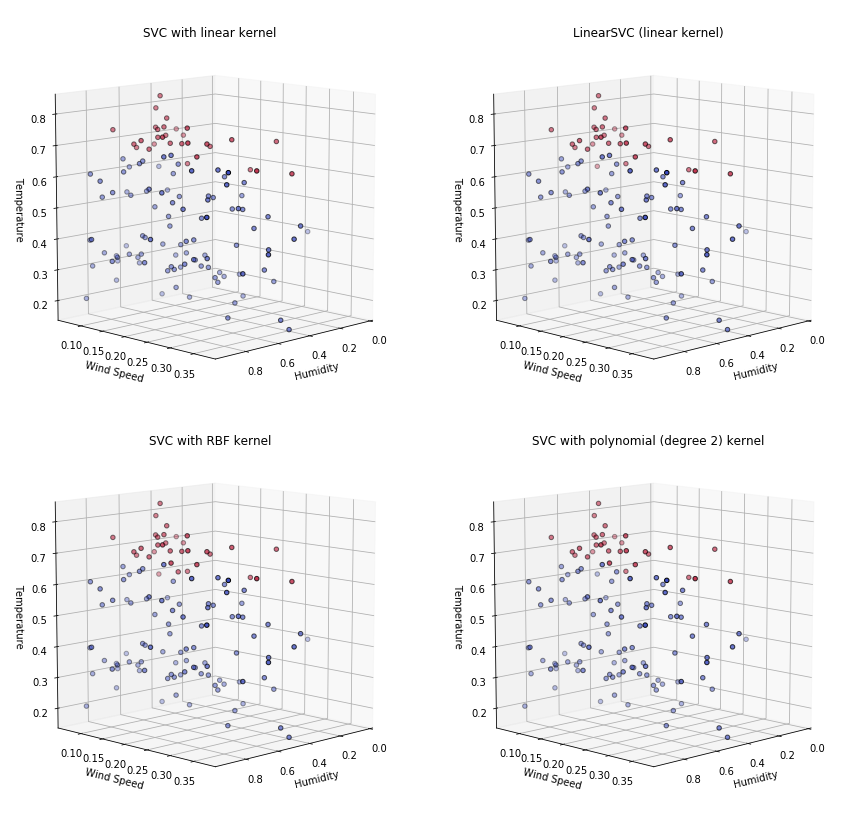

In [431]:
models = (svm.SVC(kernel='linear', C=linear_search.best_params_['C']),
          svm.LinearSVC(C=linear_search.best_params_['C']),
          svm.SVC(kernel='rbf', gamma=gaussian_search.best_params_['gamma'], C=gaussian_search.best_params_['C']),
          svm.SVC(kernel='poly', degree=polynomial_search.best_params_['degree'], C=polynomial_search.best_params_['C']))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree '+str(polynomial_search.best_params_['degree'])+') kernel')

# Set-up 2x2 grid for plotting.
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplots_adjust(wspace=0.1, hspace=0.0)

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

sub = [ax1, ax2, ax3, ax4]

X0, X1, X2 = tX[:, 0], tX[:, 1], tX[:, 2]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub):
    print('Accuracy of ',title,' is: ',clf.score(tX,ty)*100,'%',sep='')
    Z = clf.predict(tX)
#    plot_contours(ax, clf, xx, yy,
#                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, X2, c=Z, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(X0.min(), X0.max())
    ax.set_ylim(X1.min(), X1.max())
    ax.set_zlim(X2.min(), X2.max())
    ax.set_xlabel('Humidity')
    ax.set_ylabel('Wind Speed')
    ax.set_zlabel('Temperature')
    ax.view_init(10, 45)
    ax.set_title(title)
plt.show()
plt.close()
